In [2]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from shutil import copyfile

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

In [22]:
# 이미지 데이터 경로 설정
data_dir = 'face_sample_300' # 폴더 경로 설정 (2,100장 테스트)
input_shape = (224, 224)
batch_size = 32
num_classes = 7  # 클래스 개수에 맞게 설정

# 훈련셋, 검증셋, 테스트셋으로 데이터 나누기

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.3,  # 훈련셋 70%, 검증셋 30%
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# 훈련셋, 검증셋, 테스트셋으로 데이터 나누기
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,  # 훈련셋 80%, 검증셋 20%
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# 훈련셋 제너레이터 생성
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # 'training' subset은 훈련셋으로 사용
)

# 검증셋 제너레이터 생성
valid_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 'validation' subset은 검증셋으로 사용
)

# 테스트셋 제너레이터 생성
test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset=None  # 테스트셋은 따로 구분하지 않음
)

Found 1680 images belonging to 7 classes.
Found 420 images belonging to 7 classes.
Found 2100 images belonging to 7 classes.


In [23]:
def DenseNet(x):
    # input = 224 x 224 x 3
    k = 32  # Grow Rate
    compression = 0.5   # 밀집 블록 내에서 출력 채널 수를 줄임 (모델의 파라미터 수와 연산량을 줄이면서도 효과적인 특성 추출)

    # 1. Convolution
    # 입력 이미지에 7x7 크기의 필터를 사용하는 Convolution 레이어를 적용
    x = layers.Conv2D(k * 2, (7, 7), strides=2, padding='same', input_shape=(224, 224, 3))(x)    # 112x112x64
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 2. Pooling
    # 이미지 내의 중요한 특성을 보존하면서 크기를 줄임
    x = layers.MaxPool2D((3, 3), 2, padding='same')(x)  # 56x56x64

    # 3. Dense Block (1)
    # Convolution 레이어를 연속으로 쌓아서 Dense Block을 만듦
    for i in range(6) :
        x_l = layers.Conv2D(k * 4, (1, 1), strides=1, padding='same')(x)    # 56x56x128
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x_l = layers.Conv2D(k, (3, 3), strides=1, padding='same')(x_l)  # 56x56x32
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x = layers.Concatenate()([x, x_l])  # 96 -> 128 -> 160 -> 192 -> 224 -> 256

    # 4. Transition Layer (1)
    # Dense Block 이후에 위치하며, 채널 수를 줄이기 위한 역할을 함
    current_shape = int(x.shape[-1]) # 56x56x256
    x = layers.Conv2D(int(current_shape * compression), (1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.AveragePooling2D((2, 2), strides=2, padding='same')(x)   # 28x28

    # 5. Dense Block (2)
    for i in range(12) :
        x_l = layers.Conv2D(k * 4, (1, 1), strides=1, padding='same')(x)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x_l = layers.Conv2D(k, (3, 3), strides=1, padding='same')(x_l)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x = layers.Concatenate()([x, x_l])

    # 6. Transition Layer (2)
    current_shape = int(x.shape[-1])
    x = layers.Conv2D(int(current_shape * compression), (1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.AveragePooling2D((2, 2), strides=2, padding='same')(x)   # 14x14

    # 7. Dense Block (3)
    for i in range(24) :
        x_l = layers.Conv2D(k * 4, (1, 1), strides=1, padding='same')(x)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x_l = layers.Conv2D(k, (3, 3), strides=1, padding='same')(x_l)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x = layers.Concatenate()([x, x_l])

    # 8. Transition Layer (3)
    current_shape = int(x.shape[-1])
    x = layers.Conv2D(int(current_shape * compression), (1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.AveragePooling2D((2, 2), strides=2, padding='same')(x)   # 7x7

    # 9. Dense Block (4)
    for i in range(16) :
        x_l = layers.Conv2D(k * 4, (1, 1), strides=1, padding='same')(x)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x_l = layers.Conv2D(k, (3, 3), strides=1, padding='same')(x_l)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x = layers.Concatenate()([x, x_l])

    # 10. Classification Layer
    x = layers.GlobalAveragePooling2D()(x)
    # classes = 7 (softmax)
    x = layers.Dense(7, activation='softmax')(x)

    return x

In [24]:
# 모델 생성
input_layer = layers.Input(shape=(*input_shape, 3), dtype='float32', name='input')
output_layer = DenseNet(input_layer)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [25]:
# 클래스 개수 설정
num_classes = 7

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy',  # 다중 클래스 분류용 함수
              metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_360 (Conv2D)         (None, 112, 112, 64)         9472      ['input[0][0]']               
                                                                                                  
 batch_normalization_360 (B  (None, 112, 112, 64)         256       ['conv2d_360[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_360 (Activation  (None, 112, 112, 64)         0         ['batch_normalization_36

In [27]:
# 모델 학습
epochs = 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size
)

# 훈련 과정의 손실과 정확도 추출
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# 테스트셋 평가
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

# 결과 출력
print("Training Loss:", train_loss)
print("Training Accuracy:", train_acc)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/50


TypeError: 'NoneType' object is not callable

In [ ]:
# 클래스 이름과 인덱스 매핑 출력
print(train_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


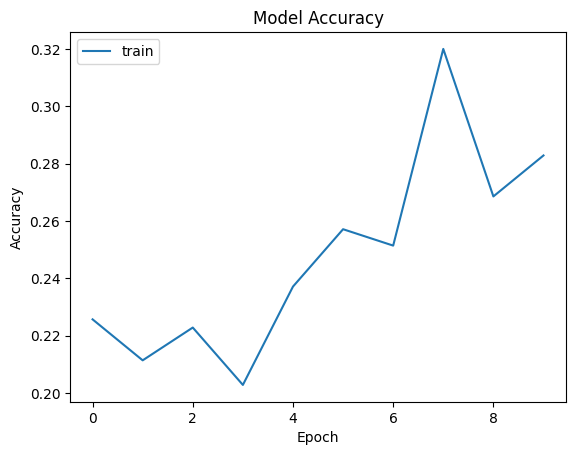

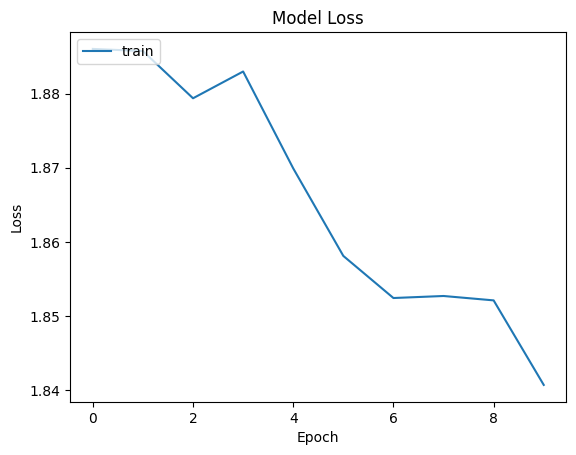

In [ ]:
# Accuracy 그래프
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
